In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
import matplotlib.pylab as pl
import time
import cv2 as cv
import ot
import math

In [2]:
I1 = plt.imread('data/coucher.jpg')
I2 = plt.imread('data/ocean.jpg')
m = I1[100:250, 450:650, :]/255
h = I2[250:400,380:580,:]/255
b = m.shape[2]
nL = m.shape[0]
nC = m.shape[1]

In [3]:
def im2vect(Img):
    b = Img.shape[2]
    nL = Img.shape[0]
    nC = Img.shape[1]
    vect = []
    for i in range(b):
        for j in range(nL):
            vect = np.concatenate((vect, Img[j,:,i].tolist()), axis=None)
    return vect    


def vect2Im(vect, shape):
    b = shape[2]
    nL = shape[0]
    nC = shape[1]
    image = []
    for k in range(nL):
        C = []
        for i in range(nC):
            B = []
            for j in range(b):
                  B = np.concatenate((B, vect[j*nC*nL + i + k*nC]), axis = None)
            C.append(B.tolist())
        image.append(C)
    image = np.array(image)
    return image

In [4]:
Y_h = m
Y_h.shape

(150, 200, 3)

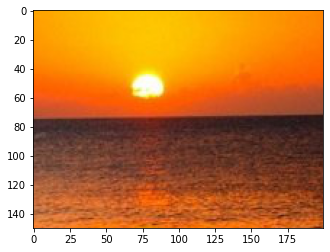

In [5]:
plt.imshow(Y_h)

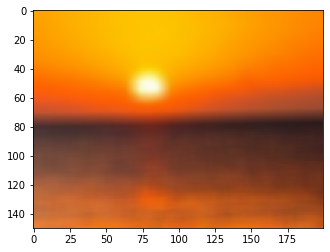

In [6]:
Z1 = cv.blur(m,(10,10)) 
plt.imshow(Z1)

In [7]:
u = Z1
v = Y_h
N = u.shape[0]
M = u.shape[1]

# Test

In [8]:
random_state = np.random.RandomState(None)
Teta = random_state.normal(0., 1., [5, 3])
np.linalg.norm(Teta)
norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
Teta = Teta / norm

In [9]:
Teta1 = Teta[0]

In [10]:
uteta = np.zeros(N*M)
vteta = np.zeros(N*M)
for i in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
    uteta[i] = np.dot(u[np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)], Teta1)
    vteta[i] = np.dot(v[np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)], Teta1)

In [11]:
Iu_sorted = np.argsort(uteta)
Iv_sorted = np.argsort(vteta)
sigma = np.zeros(N*M)
sigma[Iu_sorted] = Iv_sorted

In [12]:
Iu_sorted

array([ 1089,  1289,  4675, ..., 10281, 10280, 10481])

In [13]:
sigma

array([ 6021.,  5022.,  3530., ..., 29197., 28938., 28730.])

In [14]:
np.dot(u[np.int(np.floor(0/M)), np.int(0 - np.floor(0/M)*M)] - v[np.int(np.floor(sigma[0]/M)), np.int(sigma[0] - np.floor(sigma[0]/M)*M)], Teta[0])*Teta[0]

array([ 1.14115251e-06,  5.04497871e-07, -3.80035873e-06])

# Implémentation Gradient de Sliced Wasserstein

In [83]:
def SWgrad(u,v, nbProj):#Pour deux images de même taille
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    random_state = np.random.RandomState(None)
    Teta = random_state.normal(0., 1., [nbProj, d])
    np.linalg.norm(Teta)
    norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
    Teta = Teta / norm
    Res = np.zeros((N,M,d))
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        for j in range(N*M):
                Res[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = Res[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
        #Res[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = Res[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
    Res = Res*2/nbProj
    
    return Res
                

In [16]:
def SWgrad_UP(u,v,nbProj):#Pour deux images de même taille
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    random_state = np.random.RandomState(None)
    Teta = random_state.normal(0., 1., [nbProj, d])
    np.linalg.norm(Teta)
    norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
    Teta = Teta / norm
    Res = np.zeros((N,M,d))
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        v_sig = np.zeros((N,M,d))
        teta = np.zeros((N,M,d))
        for j in range(N*M):
            v_sig[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)]
            if(j<N):
                teta[j,j] = Teta[i]
            
        Res = Res + np.dot(u - v_sig, teta)*Teta[i]
        
    Res = Res*2/nbProj
    
    return Res
    

# Descente de gradient

In [85]:
def gradientDesc_L2Reg(u, v, nbIt, nbProj, tau, Lbd_L, Lbd_S):
    w = u
    for i in range(nbIt):
        sw_grad = SWgrad(w, v, nbProj)
        L2grad = Lbd_L*(w - u)
        w = w - tau*(L2grad + Lbd_S*sw_grad)
        
    return w

# Essais

In [86]:
t0 = time.time()
w = gradientDesc_L2Reg(Z1, Y_h, 40, 5, 0.1, 0.1, 1)
t1 = time.time()
print('temps ex : ', t1-t0)

temps ex :  206.6916801929474


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


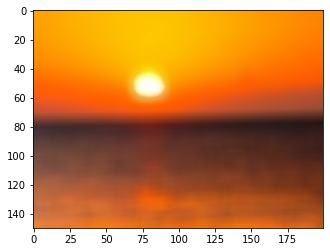

In [87]:
plt.imshow(w)